# Polynomial chaos is sensitive to the degree

## Introduction

In this example, we observe the sensitivity of the polynomial chaos expansion to the total degree of the polynomial. More precisely, we observe how this impacts the $Q^2$ predictivity coefficient.

We consider the example of the cantilever beam. We create a sparse polynomial chaos with a linear enumeration rule and the family of orthogonal polynomials corresponding to each input variable. 

In [1]:
import openturns as ot
import numpy as np
import openturns.viewer
import pylab as pl

The following parameter value leads to fast simulations.

In [2]:
maxDegree = 4

To make real tests, we suggest to use the following parameter value.

In [3]:
# maxDegree = 7 

We define the parameters of the cantilever beam problem.

In [4]:
dist_E = ot.Beta(0.9, 2.2, 2.8e7, 4.8e7)
dist_E.setDescription(["E"])
F_para = ot.LogNormalMuSigma(3.0e4, 9.0e3, 15.0e3)  # in N
dist_F = ot.ParametrizedDistribution(F_para)
dist_F.setDescription(["F"])
dist_L = ot.Uniform(250.0, 260.0)  # in cm
dist_L.setDescription(["L"])
dist_I = ot.Beta(2.5, 1.5, 310.0, 450.0)  # in cm^4
dist_I.setDescription(["I"])

myDistribution = ot.ComposedDistribution([dist_E, dist_F, dist_L, dist_I])

dim_input = 4  # dimension of the input
dim_output = 1  # dimension of the output


def function_beam(X):
    E, F, L, I = X
    Y = F * L ** 3 / (3 * E * I)
    return [Y]

g = ot.PythonFunction(dim_input, dim_output, function_beam)
g.setInputDescription(myDistribution.getDescription())

The following function creates a sparse polynomial chaos with a given total degree.

In [5]:
def ComputeSparseLeastSquaresChaos(
    inputTrain, outputTrain, multivariateBasis, totalDegree, myDistribution
):
    """
    Create a sparse polynomial chaos based on least squares.
    
    * Uses the enumerate rule in multivariateBasis. 
    * Uses the LeastSquaresStrategy to compute the coefficients based on 
      least squares. 
    * Uses LeastSquaresMetaModelSelectionFactory to use the LARS selection method. 
    * Uses FixedStrategy in order to keep all the coefficients that the 
      LARS method selected.

    Parameters
    ----------
    inputTrain : ot.Sample
        The input design of experiments.
    outputTrain : ot.Sample
        The output design of experiments.
    multivariateBasis : ot.Basis
        The multivariate chaos basis.
    totalDegree : int
        The total degree of the chaos polynomial.
    myDistribution : ot.Distribution.
        The distribution of the input variable.
    Returns
    -------
    result : ot.PolynomialChaosResult
        The estimated polynomial chaos.
    """
    selectionAlgorithm = ot.LeastSquaresMetaModelSelectionFactory()
    projectionStrategy = ot.LeastSquaresStrategy(
        inputTrain, outputTrain, selectionAlgorithm
    )
    enumfunc = multivariateBasis.getEnumerateFunction()
    P = enumfunc.getStrataCumulatedCardinal(totalDegree)
    adaptiveStrategy = ot.FixedStrategy(multivariateBasis, P)
    chaosalgo = ot.FunctionalChaosAlgorithm(
        inputTrain, outputTrain, myDistribution, adaptiveStrategy, projectionStrategy
    )
    chaosalgo.run()
    result = chaosalgo.getResult()
    return result

The following function computes  the sparsity rate of the polynomial chaos. To do this, we compute number of coefficients in the decomposition assuming a linear enumerate rule and a fixed truncation. The sparsity rate is the complement of the ratio between the number of coefficients selected from LARS and the total number of coefficients in the full polynomial basis.

In [6]:
def computeSparsityRate(multivariateBasis, totalDegree, chaosResult):
    """Compute the sparsity rate, assuming a FixedStrategy."""
    # Get P, the maximum possible number of coefficients
    enumfunc = multivariateBasis.getEnumerateFunction()
    P = enumfunc.getStrataCumulatedCardinal(totalDegree)
    # Get number of coefficients in the selection
    indices = chaosResult.getIndices()
    nbcoeffs = indices.getSize()
    # Compute rate
    sparsityRate = 1.0 - nbcoeffs / P
    return sparsityRate

The following functions compute and plots the Q2 predictivity coefficients within the validation plot.

In [7]:
def computeQ2Chaos(chaosResult, inputTest, outputTest):
    """Compute the Q2 of a chaos."""
    metamodel = chaosResult.getMetaModel()
    val = ot.MetaModelValidation(inputTest, outputTest, metamodel)
    Q2 = val.computePredictivityFactor()
    Q2 = max(Q2, 0.0)  # We are not lucky every day.
    return Q2

In [8]:
def printChaosStats(multivariateBasis, chaosResult, inputTest, outputTest, totalDegree):
    """Print statistics of a chaos."""
    sparsityRate = computeSparsityRate(multivariateBasis, totalDegree, chaosResult)
    Q2 = computeQ2Chaos(chaosResult, inputTest, outputTest)
    metamodel = chaosResult.getMetaModel()
    val = ot.MetaModelValidation(inputTest, outputTest, metamodel)
    graph = val.drawValidation()
    legend1 = "D=%d, Q2=%.2f%%" % (totalDegree, 100 * Q2)
    graph.setLegends(["", legend1])
    graph.setLegendPosition("topleft")
    print(
        "Degree=%d, Q2=%.2f%%, Sparsity=%.2f%%"
        % (totalDegree, 100 * Q2, 100 * sparsityRate)
    )
    return graph

In [9]:
multivariateBasis = ot.OrthogonalProductPolynomialFactory(
    [dist_E, dist_F, dist_L, dist_I]
)

In [10]:
N = 20  # size of the train design

In [11]:
n_valid = 1000  # size of the test design

The seed is selected to get *interesting* results. 

In [12]:
magicSeed = 43  # 127 is funny too
ot.RandomGenerator.SetSeed(magicSeed) 

Degree=1, Q2=96.41%, Sparsity=20.00%
Degree=2, Q2=96.23%, Sparsity=46.67%
Degree=3, Q2=93.07%, Sparsity=71.43%
Degree=4, Q2=75.96%, Sparsity=91.43%


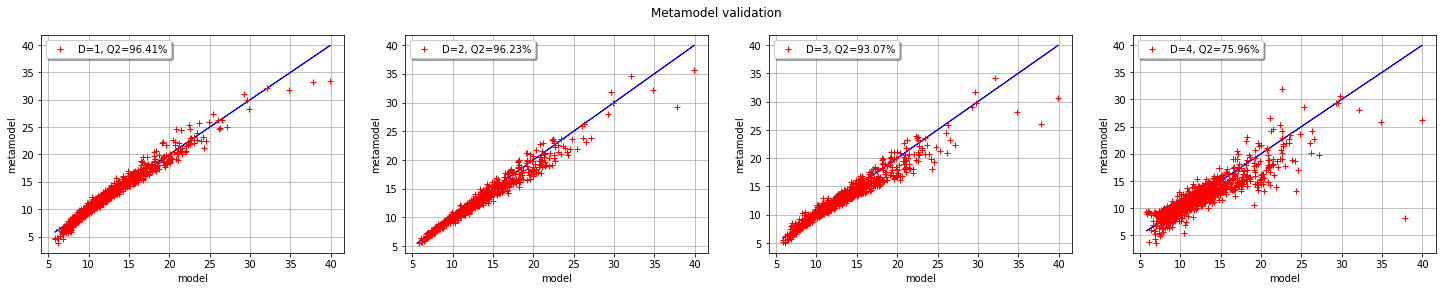

In [13]:
inputTrain = myDistribution.getSample(N)
outputTrain = g(inputTrain)
inputTest = myDistribution.getSample(n_valid)
outputTest = g(inputTest)
fig = pl.figure(figsize=(25, 4))
for totalDegree in range(1, maxDegree + 1):
    chaosResult = ComputeSparseLeastSquaresChaos(
        inputTrain, outputTrain, multivariateBasis, totalDegree, myDistribution
    )
    graph = printChaosStats(
        multivariateBasis, chaosResult, inputTest, outputTest, totalDegree
    )
    ax = fig.add_subplot(1, maxDegree, totalDegree)
    _ = ot.viewer.View(graph, figure=fig, axes=[ax])
    pl.suptitle("Metamodel validation")

We see that, when the degree of the polynomial increases, then the Q2 coefficient decreases. We also see that the sparsity rate increases which shows that, while the basis size grows rapidly with the degree, the algorithm selects a smaller fraction of this basis. This shows that the algorithm performs its taks of selecting relevant coefficients. However, this selection does not seem to be sufficient to mitigate the large number of coefficients. 

Of cours, this example has been selected to make a gradually decreasing predictivity. We are going to see that this situation is actually easy to reproduce. 

## Distribution of the predictivity coefficient

Let us repeat the following experiment to see the variability of the Q2 coefficient.

In [14]:
def computeSampleQ2(N, n_valid, numberAttempts, maxDegree):
    """For a given sample size N, for degree from 1 to maxDegree, 
    repeat the following experiment numberAttempts times:
    create a sparse least squares chaos and compute the Q2 
    using n_valid points.
    """
    Q2sample = ot.Sample(numberAttempts, maxDegree)
    for totalDegree in range(1, maxDegree + 1):
        print("Degree = %d" % (totalDegree))
        for i in range(numberAttempts):
            inputTrain = myDistribution.getSample(N)
            outputTrain = g(inputTrain)
            inputTest = myDistribution.getSample(n_valid)
            outputTest = g(inputTest)
            chaosResult = ComputeSparseLeastSquaresChaos(
                inputTrain, outputTrain, multivariateBasis, totalDegree, myDistribution
            )
            Q2sample[i, totalDegree - 1] = computeQ2Chaos(
                chaosResult, inputTest, outputTest
            )
    return Q2sample

The following function uses a boxplot to see the distribution of the Q2 coefficients.

In [15]:
def plotQ2Boxplots(Q2sample, N):
    data = np.array(Q2sample)
    fig = pl.figure()
    pl.boxplot(data)
    pl.title("N=%d" % (N))
    pl.xlabel("Degree")
    pl.ylabel("Q2 (%)")
    return

Each experiment is repeated a number of times. 

In [16]:
numberAttempts = 50  # Number of repetitions

Degree = 1
Degree = 2
Degree = 3
Degree = 4


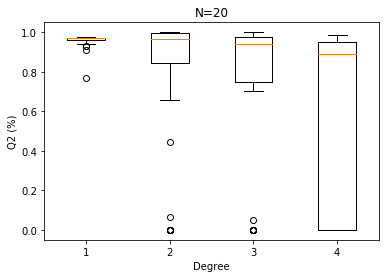

In [17]:
N = 20  # size of the train design
Q2sample = computeSampleQ2(N, n_valid, numberAttempts, maxDegree)
plotQ2Boxplots(Q2sample, N)

We see that when the size of the design of experiments is as small as 20, it is more appropriate to use a very low degree polynomial equal to 1. Considering the polynomial degree 4 is risky. 

Degree = 1
Degree = 2
Degree = 3
Degree = 4


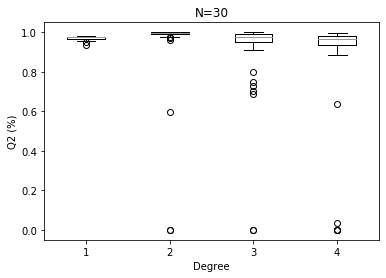

In [18]:
N = 30  # size of the train design
Q2sample = computeSampleQ2(N, n_valid, numberAttempts, maxDegree)
plotQ2Boxplots(Q2sample, N)

We a sample size equal to 30, we can generally use a polynomial degree equal to 2.

Degree = 1
Degree = 2
Degree = 3
Degree = 4


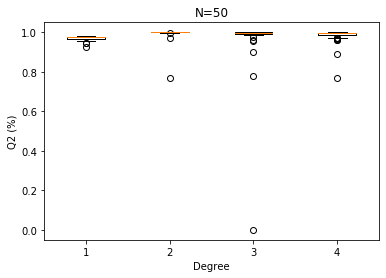

In [19]:
N = 50  # size of the train design
Q2sample = computeSampleQ2(N, n_valid, numberAttempts, maxDegree)
plotQ2Boxplots(Q2sample, N)

When the sample size increases, the Q2 computation becomes less sensitive to the polynomial degree.

## Conclusion

We observe that on the cantilever beam example, to use a polynomial total degree equal to 4, we need a sample size at least equal to 50 to get a satisfactory and reproducible Q2. When the degree is equal to 4, if we use a small sample size, then, depending on the particular sample, the predictivity coefficient can be very low (i.e less than 0.5). When the sample size as small as 20, then a polynomial degree equal to 1 is safer in this case, but the limited sample size may have an impact on other statistics that we may derive from a metamodel that was calculated on such a small training sample.

## References

* "Metamodel-Based Sensitivity Analysis: Polynomial Chaos Expansions and Gaussian Processes", Loïc Le Gratiet,  Stefano Marelli, Bruno Sudret, Handbook of Uncertainty Quantification, 2017, Springer International Publishing.